In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# EMA Workbench imports
import ema_workbench
from ema_workbench import (
    Model, Constraint, RealParameter, ScalarOutcome, MultiprocessingEvaluator,
    ema_logging, Constant, Scenario, HypervolumeMetric,
    GenerationalDistanceMetric, EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric, SpacingMetric)
from ema_workbench.em_framework.optimization import (
    EpsilonProgress, to_problem, ArchiveLogger, epsilon_nondominated)
from ema_workbench.analysis import parcoords

# Problem formulation import
from problem_formulation import get_model_for_problem_formulation

c:\Users\quint\Documents\Ralph\.venv\Lib\site-packages\ema_workbench\em_framework\__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


In [3]:
#Constants
output_dir = 'archives'
scenario_file = './data/Selected_Scenarios.csv'
epsilon_values = [[1e6, 1e6, 1e6, 1e6, 1e6]]
nfe = 20000
outcomes_of_interest = [
    'Expected Annual Damage',
    'Dike Investment Costs',
    'RfR Investment Costs',
    'Evacuation Costs',
    'Expected Number of Deaths'
]

In [4]:
def run_optimization(epsilon, scenarios, model, seeds=3):
    
    results = []
    convergences = []

    os.makedirs(output_dir, exist_ok=True)

    with MultiprocessingEvaluator(model) as evaluator:
        for scenario in scenarios:
            for seed in range(seeds):
                # Convergence Metrics
                convergence_metrics = [
                    ArchiveLogger(
                        output_dir,
                        [lever.name for lever in model.levers],
                        [outcome.name for outcome in model.outcomes],
                        base_filename="optimization.tar.gz"
                    ),
                    EpsilonProgress()
                ]

                # Optimization
                result, convergence = evaluator.optimize(
                    nfe=nfe,
                    searchover="levers",
                    epsilons=epsilon,
                    constraints=None,
                    convergence=convergence_metrics,
                    reference=scenario
                )

                # Filenames
                result_file = os.path.join(output_dir, f"result__scen{scenario.name}__seed{seed}.csv")
                convergence_file = os.path.join(output_dir, f"convergence__scen{scenario.name}__seed{seed}.csv")

                # Output
                result.to_csv(result_file, index=False)
                pd.DataFrame(convergence).to_csv(convergence_file, index=False)

                # Saving Output
                results.append(result)
                convergences.append(convergence)

    return results, convergences

In [5]:
def load_results_from_files(directory):
    """
    Loads all optimization result CSVs from a directory into a single DataFrame.
    """
    results = []
    for filename in os.listdir(directory):
        if filename.startswith("result__") and filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            results.append(df)
    return pd.concat(results, ignore_index=True)

[MainProcess/INFO] pool started with 24 workers
20318it [05:19, 63.64it/s]                                                     
[MainProcess/INFO] optimization completed, found 225 solutions
20011it [05:54, 56.49it/s]                                                     
[MainProcess/INFO] optimization completed, found 202 solutions
20437it [06:47, 50.17it/s]                                                     
[MainProcess/INFO] optimization completed, found 180 solutions
20506it [07:17, 46.90it/s]                                                     
[MainProcess/INFO] optimization completed, found 263 solutions
20120it [07:28, 44.81it/s]                                                     
[MainProcess/INFO] optimization completed, found 322 solutions
20560it [07:40, 44.68it/s]                                                     
[MainProcess/INFO] optimization completed, found 304 solutions
20098it [07:16, 46.00it/s]                                                     
[MainProcess/I

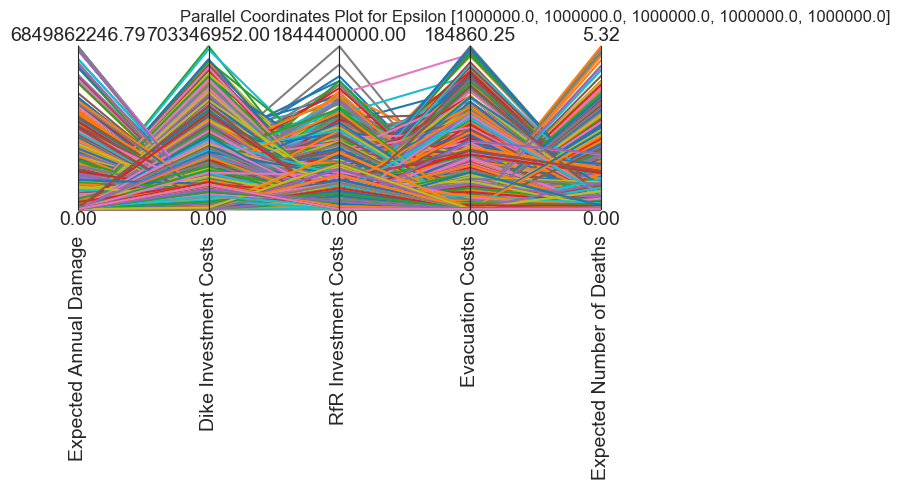

In [6]:
def ensure_directory_exists(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)

def load_scenarios(filepath):
    df = pd.read_csv(filepath)
    scenarios = []
    for _, row in df.iterrows():
        name = row['scenario']
        parameters = row.drop(labels='scenario').to_dict()
        scenarios.append(Scenario(name, **parameters))
    return scenarios

def plot_parallel_coordinates(results, eps):
    outcomes = results[outcomes_of_interest]
    limits = parcoords.get_limits(outcomes)
    axes = parcoords.ParallelAxes(limits)
    axes.plot(outcomes)
    plt.title(f'Parallel Coordinates Plot for Epsilon {eps}')
    plt.savefig(f'parallel_coordinates_eps_{eps}.png')
    plt.show()

def main():
    ema_logging.log_to_stderr(ema_logging.INFO)
    
    ensure_directory_exists(output_dir)

    model, steps = get_model_for_problem_formulation(2)
    scenarios = load_scenarios(scenario_file)

    for eps in epsilon_values:
        results, convergences = run_optimization(eps, scenarios, model)
        all_results = load_results_from_files(output_dir)
        plot_parallel_coordinates(all_results, eps)

if __name__ == '__main__':
    main()

In [7]:
def get_minimizing_policies(objectives: np.ndarray) -> np.ndarray:
    """
    Return a boolean mask indicating Pareto-optimal (non-dominated) policies.
    Assumes all objectives are to be minimized.
    """
    is_efficient = np.ones(objectives.shape[0], dtype=bool)
    for i, c in enumerate(objectives):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(objectives[is_efficient] < c, axis=1) | np.all(objectives[is_efficient] == c, axis=1)
            is_efficient[i] = True
    return is_efficient

In [8]:
def filter_pareto_optimal_policies(df, objectives):
    """
    Filters a DataFrame to retain only the Pareto-optimal rows (minimization).
    """
    objective_values = df[objectives].values
    pareto_mask = get_minimizing_policies(objective_values)
    return df[pareto_mask]


In [9]:
# After running main()
all_results = load_results_from_files(output_dir)
pareto_results = filter_pareto_optimal_policies(all_results, outcomes_of_interest)
pareto_results.to_csv("Pareto_Optimal_Results.csv", index=False)
print("Saved Pareto-optimal policies to pareto_optimal_results.csv")

Saved Pareto-optimal policies to pareto_optimal_results.csv
